In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from toolz import partial
from pathlib import Path
from aging.plotting import format_plots, figure, legend, add_identity
import colorcet as cc
from tqdm.auto import tqdm
from sklearn.decomposition import PCA, NMF
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_predict, LeaveOneGroupOut
from sklearn.pipeline import make_pipeline
from scipy.spatial.distance import pdist, squareform

In [2]:
def reindex_c(df1, df2):
    return df1.reindex(columns=df2.columns).fillna(0)

In [3]:
dotted_identity = partial(add_identity, linestyle='--', color='k')

In [4]:
format_plots()

In [5]:
version = 8
folder = Path(f"/n/groups/datta/win/longtogeny/data/ontogeny/version_{version:02d}")

In [6]:
usages = pd.read_parquet(folder / "ontogeny_males_clean_v2.parquet").fillna(0).astype('float32')
long_usages = pd.read_parquet(folder / "longtogeny_males_clean_v1.parquet").fillna(0).astype('float32')
long_usages = long_usages[long_usages.index.get_level_values('age') < 600]

In [7]:
keep_syll = usages.quantile(0.9) > 0.01
keep_syll = keep_syll[keep_syll].index

In [8]:
age = usages.index.get_level_values('age')
long_age = long_usages.index.get_level_values('age') / 7

/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


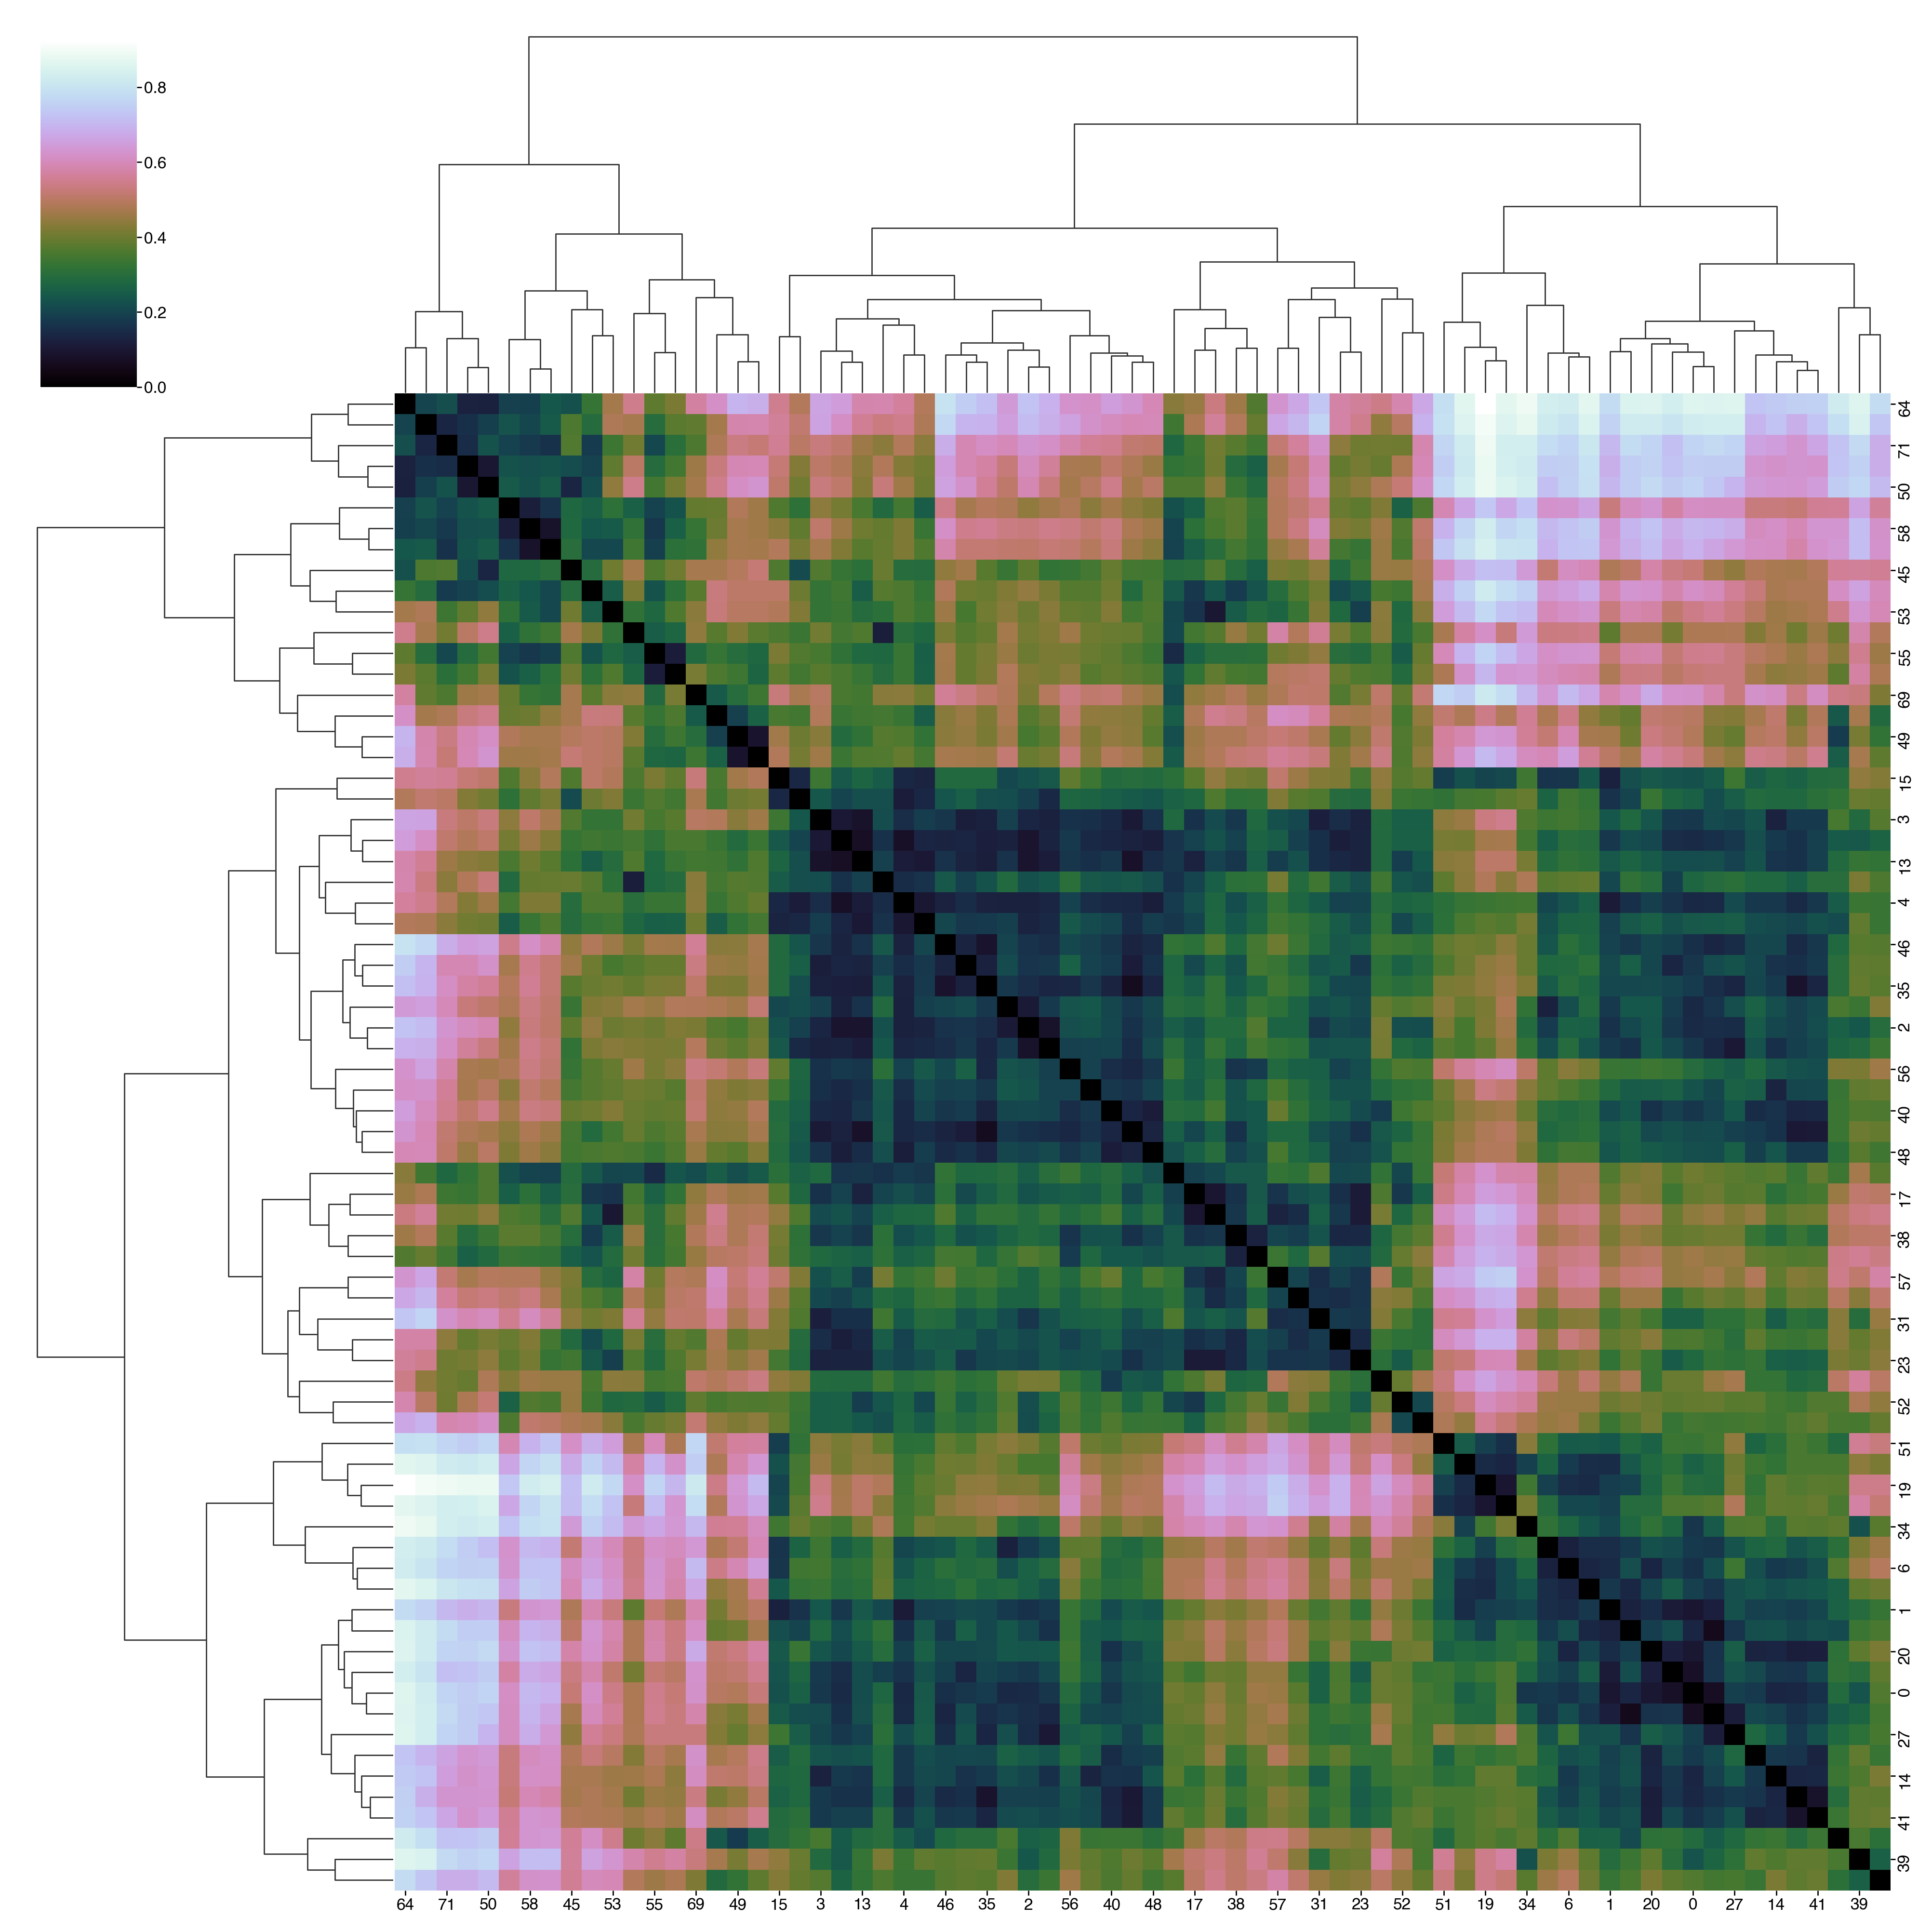

In [13]:
sns.clustermap(
    squareform(pdist(usages[keep_syll].T, metric="cosine")),
    cmap="cubehelix",
    method="complete",
)

In [15]:
recon = []
for i in range(2, 10):
    nmf = NMF(n_components=i, max_iter=1000)
    nmf.fit(usages[keep_syll])
    recon.append(nmf.reconstruction_err_)

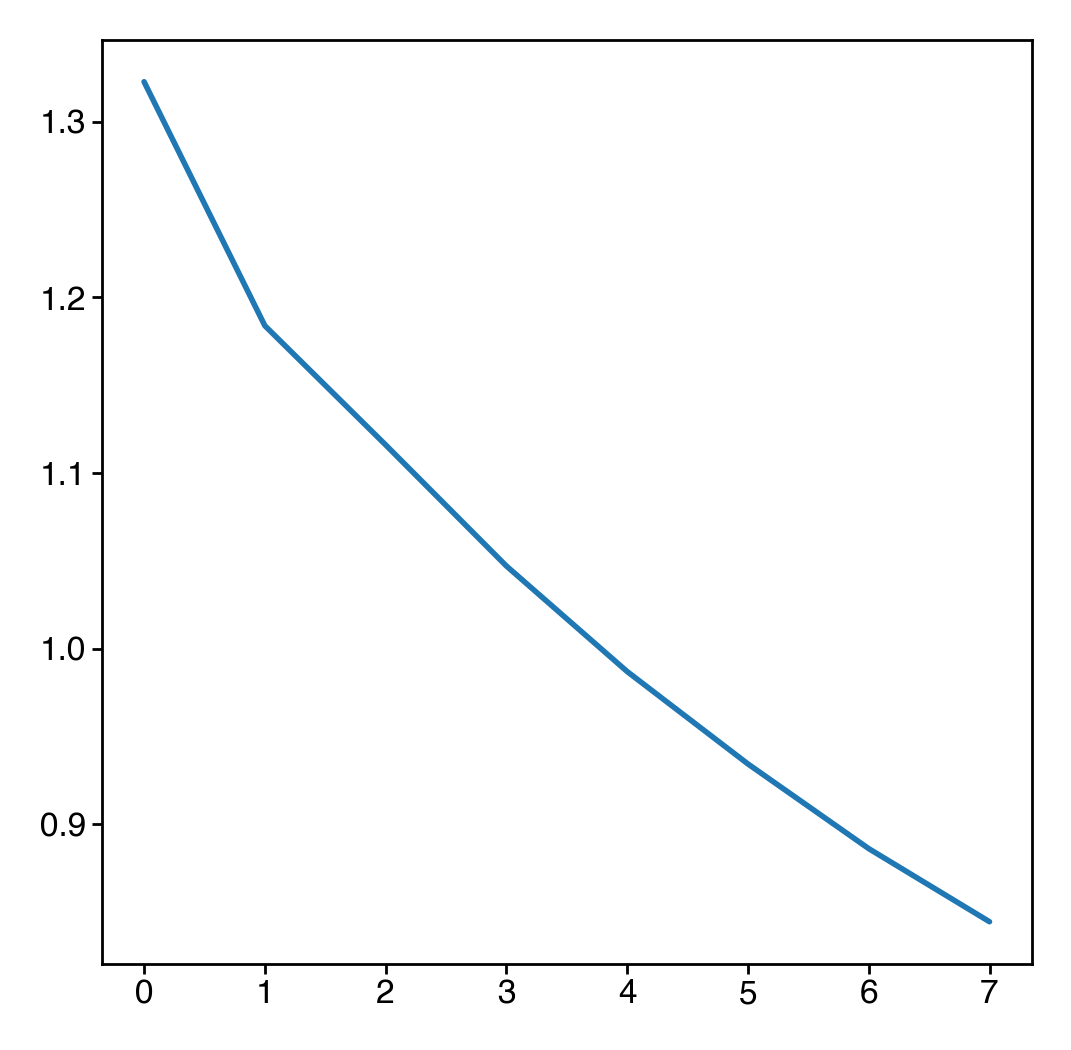

In [16]:
plt.plot(recon)

In [17]:
nmf.components_.shape

(9, 72)

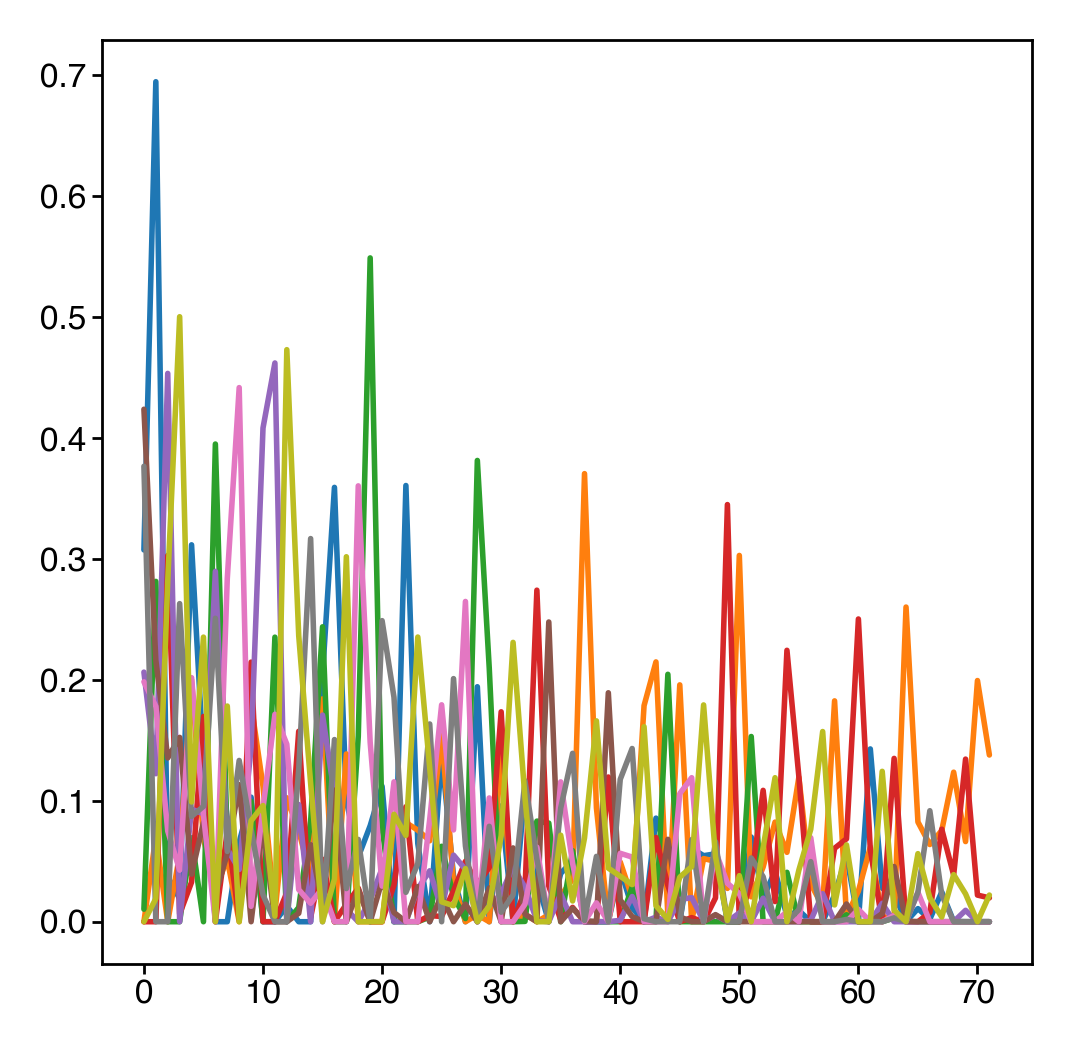

In [20]:
plt.plot(nmf.components_.T)

In [53]:
nmf = NMF(n_components=2, max_iter=1000)
scores = nmf.fit_transform(usages[keep_syll])
preds = cross_val_predict(LinearRegression(), scores, age, cv=LeaveOneGroupOut(), groups=age)
r2_score(age, preds)

0.6759753607653243

In [46]:
scores = PCA(n_components=2).fit_transform(usages[keep_syll])
preds = cross_val_predict(LinearRegression(), scores, age, cv=LeaveOneGroupOut(), groups=age)
r2_score(age, preds)

0.6771442784879871